In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

# Ensure local package visibility
current_dir = os.path.dirname(os.path.abspath(""))
sys.path.append(current_dir)
sys.path.append(os.path.join(current_dir, "rfi"))

# Scenario engine + scenario definitions
from rfi.scenario import (
    run_multi_entry_rfi_scenario,
    VICTIM_BANDS,
    INTERFERENCE_SCENARIOS,
)
from rfi.itu_models import (
    compute_thermal_noise_dbw,
    free_space_path_loss_db,
    compute_interference_power_dbw,
    compute_snr_with_interference_db,
    compute_off_axis_gain_s1528_db,
    generate_geometric_sweep,
)


In [4]:
rows = []

for band, cfg in VICTIM_BANDS.items():
    res = run_multi_entry_rfi_scenario(
        band_params=cfg,
        interferer_list=INTERFERENCE_SCENARIOS["Moderate"],
        time_sim_samples=5000,
    )

    rows.append({
        "Band": band,
        "Baseline SNR (dB)": res["Baseline SNR (dB)"],
        "ΔSNR (dB)": res["SNR Loss (dB)"],
        "P(ΔSNR > 1 dB) (%)": res["P(SNR Loss > 1 dB) (%)"],
        "P(ΔSNR > 3 dB) (%)": res["P(SNR Loss > 3 dB) (%)"],
        "P(ΔSNR > 6 dB) (%)": res["P(SNR Loss > 6 dB) (%)"],
    })

df_results = pd.DataFrame(rows).set_index("Band").round(2)
df_results


,Baseline SNR (dB),ΔSNR (dB),P(ΔSNR > 1 dB) (%),P(ΔSNR > 3 dB) (%),P(ΔSNR > 6 dB) (%)
Band,,,,,
S-band,10.05,3.07,92.80,51.70,12.74
X-band,8.03,1.00,49.70,7.80,0.40
Ku-band,23.02,0.99,50.78,7.10,0.46
K-band,30.07,1.50,69.42,17.88,1.68
Ka-band,36.55,1.98,80.26,27.86,4.04


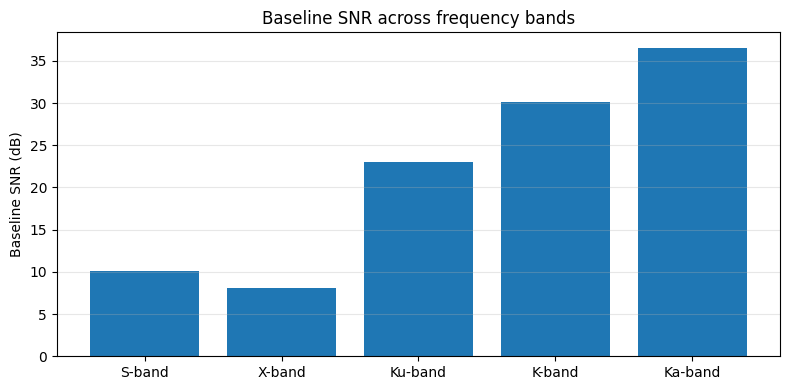

In [5]:
plt.figure(figsize=(8, 4))
plt.bar(df_results.index, df_results["Baseline SNR (dB)"])
plt.ylabel("Baseline SNR (dB)")
plt.title("Baseline SNR across frequency bands")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


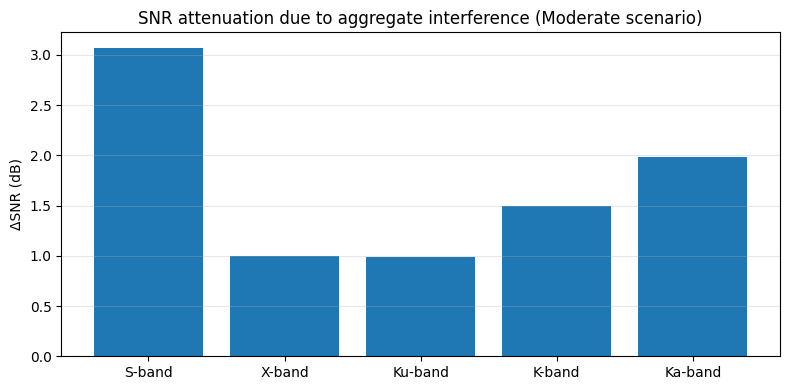

In [6]:
plt.figure(figsize=(8, 4))
plt.bar(df_results.index, df_results["ΔSNR (dB)"])
plt.ylabel("ΔSNR (dB)")
plt.title("SNR attenuation due to aggregate interference (Moderate scenario)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


In [7]:
scenario_names = list(INTERFERENCE_SCENARIOS.keys())
heatmap_data = []

for band, cfg in VICTIM_BANDS.items():
    band_row = []
    for scenario in scenario_names:
        res = run_multi_entry_rfi_scenario(
            band_params=cfg,
            interferer_list=INTERFERENCE_SCENARIOS[scenario],
            time_sim_samples=3000,
        )
        band_row.append(res["SNR Loss (dB)"])
    heatmap_data.append(band_row)

heatmap_data = np.array(heatmap_data)


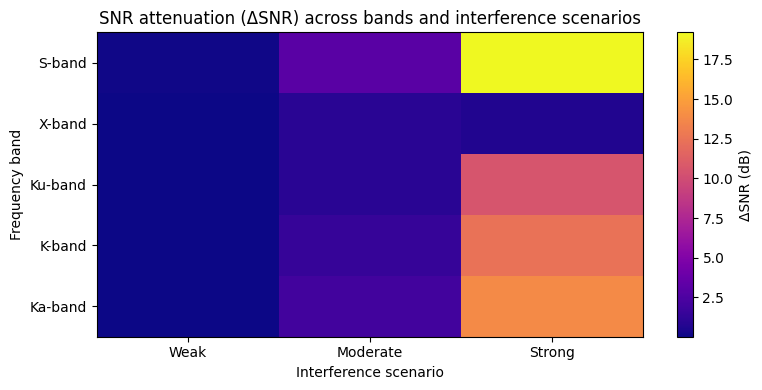

In [8]:
plt.figure(figsize=(8, 4))
im = plt.imshow(
    heatmap_data,
    aspect="auto",
    cmap="plasma"
)

plt.xticks(
    np.arange(len(scenario_names)),
    scenario_names
)
plt.yticks(
    np.arange(len(VICTIM_BANDS)),
    list(VICTIM_BANDS.keys())
)

plt.xlabel("Interference scenario")
plt.ylabel("Frequency band")
plt.title("SNR attenuation (ΔSNR) across bands and interference scenarios")

cbar = plt.colorbar(im)
cbar.set_label("ΔSNR (dB)")

plt.tight_layout()
plt.show()


In [9]:
distance_km = np.linspace(500, 40000, 40)

INTERFERER_TEMPLATE = {
    "EIRP_int_dbw": 20.0,
    "theta_off_axis_deg": 5.0,
    "sigma_db": 0.0,
    "duty_cycle": 1.0,
}

distance_heatmap = []

for band, cfg in VICTIM_BANDS.items():
    band_losses = []
    for d in distance_km:
        interferer = INTERFERER_TEMPLATE.copy()
        interferer["d_km"] = d

        res = run_multi_entry_rfi_scenario(
            band_params=cfg,
            interferer_list=[interferer],
            time_sim_samples=2000,
        )
        band_losses.append(res["SNR Loss (dB)"])

    distance_heatmap.append(band_losses)

distance_heatmap = np.array(distance_heatmap)


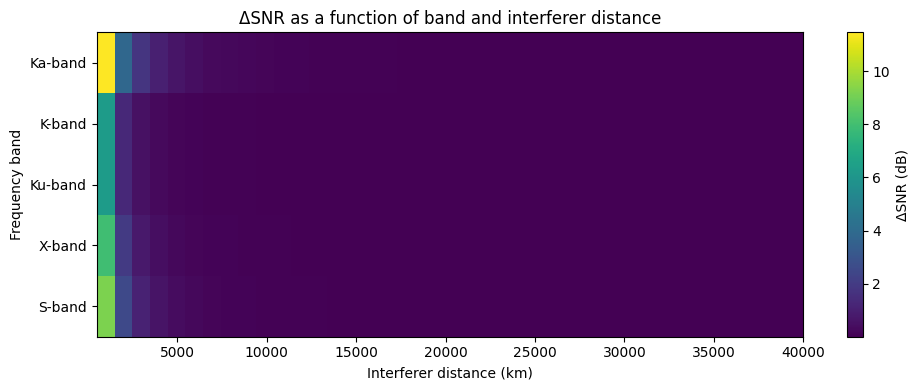

In [10]:
plt.figure(figsize=(10, 4))
im = plt.imshow(
    distance_heatmap,
    aspect="auto",
    cmap="viridis",
    extent=[distance_km[0], distance_km[-1], 0, len(VICTIM_BANDS)],
)

plt.yticks(
    np.arange(len(VICTIM_BANDS)) + 0.5,
    list(VICTIM_BANDS.keys())
)

plt.xlabel("Interferer distance (km)")
plt.ylabel("Frequency band")
plt.title("ΔSNR as a function of band and interferer distance")

cbar = plt.colorbar(im)
cbar.set_label("ΔSNR (dB)")

plt.tight_layout()
plt.show()


In [11]:
from rfi.equations_itu import (
    compute_thermal_noise_dbw,
    free_space_path_loss_db,
    compute_off_axis_gain_s1528_db,
    compute_snr_with_interference_db,
    generate_geometric_sweep,
)

x_cfg = VICTIM_BANDS["X-band"]

theta_series = generate_geometric_sweep(
    max_theta_deg=20.0,
    min_theta_deg=0.5,
    num_steps=400,
)

N_dbw = compute_thermal_noise_dbw(250.0, 1e6)
Lfs_carrier = free_space_path_loss_db(x_cfg["f_ghz"], x_cfg["d_km"])

C_dbw = (
    x_cfg["EIRP_dbw"]
    - Lfs_carrier
    + x_cfg["G_rx_db"]
)

SNR_baseline = C_dbw - N_dbw


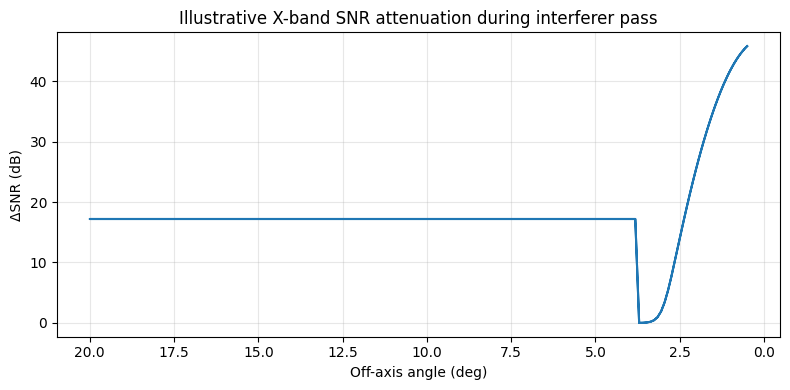

In [12]:
snr_loss_series = []

for theta in theta_series:
    g_rx = compute_off_axis_gain_s1528_db(
        g_max=x_cfg["G_rx_db"],
        theta_deg=theta,
        theta_3db=x_cfg["theta_3db"],
    )

    Lfs_int = free_space_path_loss_db(x_cfg["f_ghz"], 1000.0)

    I_dbw = 38.0 - Lfs_int + g_rx

    SNR_I = compute_snr_with_interference_db(C_dbw, N_dbw, I_dbw)
    snr_loss_series.append(SNR_baseline - SNR_I)

snr_loss_series = np.array(snr_loss_series)

plt.figure(figsize=(8, 4))
plt.plot(theta_series, snr_loss_series)
plt.gca().invert_xaxis()
plt.xlabel("Off-axis angle (deg)")
plt.ylabel("ΔSNR (dB)")
plt.title("Illustrative X-band SNR attenuation during interferer pass")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
